In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive

/content/drive/MyDrive


In [3]:
cd ecovadis

/content/drive/MyDrive/ecovadis


In [4]:
!source .venv/bin/activate

/bin/bash: line 1: .venv/bin/activate: No such file or directory


In [5]:
pip install umap transformers transformers[sentencepiece] sentencepiece emoji==0.6.0 umap-learn


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 71.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-0.6.0-py3-none-any.whl size=49721 sha256=4fd74658990bd090ce3ff3602d3e849f037bad73a8752049dd3e5cae4083aa06
  Stored in directory: /root/.cache/pip/wheels/1b/b

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import cross_val_score
import umap
import sklearn
import pandas as pd
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string
from gensim.models import Word2Vec
import numpy as np
import nltk
#import umap.plot as up
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from wordcloud import WordCloud
import gensim

from itertools import chain

from core.utils import (find_non_numerical_columns,categorize_columns,evaluate_cross_validation,
                   convert_df_to_numeric_df,scale_columns,evaluate_model,objective_xgb,preprocess_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [7]:
df = pd.read_excel("data/assignement.xlsx")
target = df["Exited"]

In [8]:
true_sentence = [ sentence for sentence in df["CustomerFeedback"].values if isinstance(sentence,str)]
true_sentence_index = [ i for i,sentence in enumerate(df["CustomerFeedback"].values) if isinstance(sentence,str)]
for position,index in enumerate(true_sentence_index) :
    assert df["CustomerFeedback"].iloc[index] == true_sentence[position]

In [9]:
#corpus_by_feedback = [ preprocess_text(text) for text in true_sentence]
corpus_by_feedback = [ nltk.sent_tokenize(text) for text in true_sentence]
corpus = list(chain.from_iterable(corpus_by_feedback))

In [19]:
corpus_by_feedback[1]

["Last week, I reached out to my bank's support team due to confusion I was having about their account disclosures and terms.",
 "After submitting a request for more information, I didn't expect the speedy response that I received.",
 'Within a couple of hours, a bank representative had reached out to me.',
 "They carefully explained the confusing parts in plain language and made sure to cover each aspect I wasn't clear on.",
 'I appreciated their patience with my inquiries, as it is super important to be knowledgeable about financial matters.',
 'All my confusion cleared up, thanks to this amazing service.',
 "It's obvious that my bank values its customers' concerns and puts effort into giving detailed, informative replies.",
 "As a customer, knowing that this kind of support is just a click away really puts me at ease, and I couldn't be more grateful!",
 'Keep up the fantastic work!']

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
true_sentence[1]

"Last week, I reached out to my bank's support team due to confusion I was having about their account disclosures and terms. After submitting a request for more information, I didn't expect the speedy response that I received.\n\nWithin a couple of hours, a bank representative had reached out to me. They carefully explained the confusing parts in plain language and made sure to cover each aspect I wasn't clear on. I appreciated their patience with my inquiries, as it is super important to be knowledgeable about financial matters.\n\nAll my confusion cleared up, thanks to this amazing service. It's obvious that my bank values its customers' concerns and puts effort into giving detailed, informative replies. As a customer, knowing that this kind of support is just a click away really puts me at ease, and I couldn't be more grateful! Keep up the fantastic work!"

In [ ]:
dictionary_based_model = SentimentIntensityAnalyzer()
corpus_by_user = [ nltk.sent_tokenize(text) for text in true_sentence]

Text(0.5, 1.0, 'Distribution of positive scores')

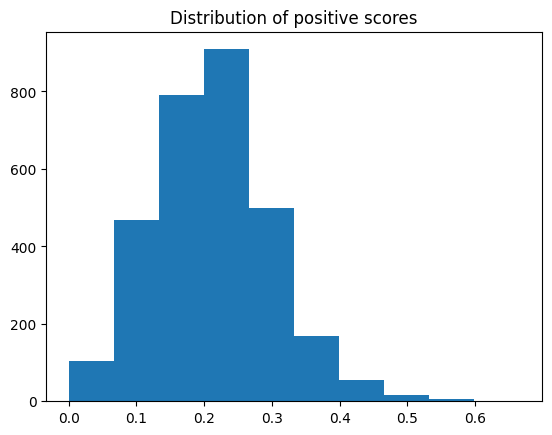

In [ ]:
sentiments_pos_score = [[dictionary_based_model.polarity_scores(sentence)["pos"] for sentence in corpus_by_user[j] ] for j in range(len(true_sentence))]
average_sentiments_pos_score = [np.mean(score) for score in sentiments_pos_score]
fig = plt.hist(average_sentiments_pos_score)
plt.title("Distribution of positive scores")

Text(0.5, 1.0, 'Distribution of negative scores')

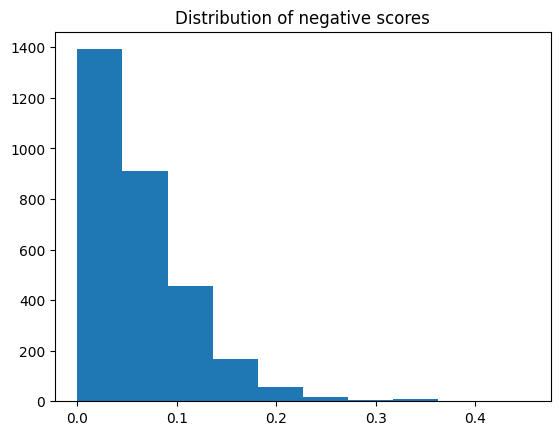

In [ ]:
sentiments_neg_score = [[dictionary_based_model.polarity_scores(sentence)["neg"] for sentence in corpus_by_user[j] ] for j in range(len(true_sentence))]
average_sentiments_neg_score = [np.mean(score) for score in sentiments_neg_score]
fig  = plt.hist(average_sentiments_neg_score)
plt.title("Distribution of negative scores")

Text(0.5, 1.0, 'Sentiment score distribution')

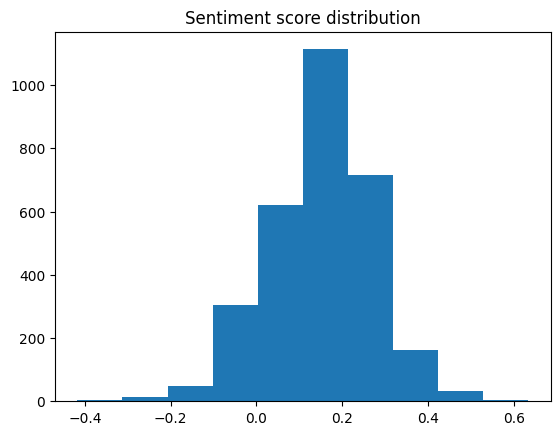

In [ ]:
average_score = [ pos - neg for pos,neg in zip(average_sentiments_pos_score,average_sentiments_neg_score)]
fig = plt.hist(average_score)
plt.title("Sentiment score distribution")

In [ ]:
labels = []
for i,scores in enumerate(average_score) :
    if scores > 0.1 :
        labels.append(2)
    elif scores < -0.05 :
        labels.append(1)
    else :
        labels.append(0)
df['SentimentsDictionnary'] = [-1 for _ in range(len(df))]
for position,index in enumerate(true_sentence_index):
    df.at[index,'SentimentsDictionnary'] = labels[position]

In [ ]:
for index in true_sentence_index :
    assert df["CustomerFeedback"].iloc[index] is not None

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(df.index.values,
                                                  df['SentimentsDictionnary'].values,
                                                  test_size=0.15,
                                                  random_state=42,
                                                  stratify=df['SentimentsDictionnary'].values)

In [ ]:
df['set'] = ['not_set']*df.shape[0]
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df = df[df["SentimentsDictionnary"] != -1]

In [ ]:
from transformers import BertTokenizer,RobertaTokenizer,BertweetTokenizer
from torch.utils.data import TensorDataset
import torch

In [ ]:
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained

In [ ]:
tokenizer = BertweetTokenizer.from_pretrained(
    'finiteautomata/bertweet-base-sentiment-analysis',
    do_lower_case=True
)

encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train']["CustomerFeedback"].values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding=True,
    max_length=100,
    return_tensors='pt',
    truncation=True
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val']["CustomerFeedback"].values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding=True,
    max_length=100,
    return_tensors='pt',
    truncation=True
)
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train']["SentimentsDictionnary"].values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val']["SentimentsDictionnary"].values)

dataset_train = TensorDataset(input_ids_train,
                              attention_masks_train,
                              labels_train)

dataset_val = TensorDataset(input_ids_val,
                            attention_masks_val,
                           labels_val)

In [ ]:
from transformers import RobertaForSequenceClassification
model = RobertaForSequenceClassification.from_pretrained(
                                      'finiteautomata/bertweet-base-sentiment-analysis',
                                      num_labels = 3,
                                      output_attentions = False,
                                      output_hidden_states = False
                                     )




In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 2

dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)

dataloader_val = DataLoader(
    dataset_val,
    sampler=RandomSampler(dataset_val),
    batch_size=32
)

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup
optimizer = AdamW(
    model.parameters(),
    lr = 1e-6,
    eps = 1e-8
)


epochs = 2

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps = len(dataloader_train)*epochs
)



/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def compute_balance_accuracy(predictions,true_vals,nb_class=3):
    nb_class = 3
    accs = [0 for _ in range(nb_class)]
    for classe in range(nb_class) :
        accs[classe] = np.sum((true_vals == np.argmax(predictions,axis=-1)) * (true_vals == classe).astype(int)) / max((true_vals == 2).sum(), 1)
    return np.mean(np.array(accs))

device = torch.device('cuda')
model = model.to(device)

In [ ]:
from tqdm import tqdm
def evaluate(model,dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in tqdm(dataloader_val):

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [ ]:
training_losses  = []
test_losses  = []
testing_accuracy  = []
training_accuracy  = []
for epoch in range(1, epochs+1):
    model.train()
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch))
    for batch in progress_bar:
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids': batch[0],
            'labels': batch[2]
        }

        outputs = model(**inputs)
        loss = outputs[0]
        loss_train_total +=loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

        val_loss, predictions, true_vals = evaluate(model,dataloader_train)
        training_acc = compute_balance_accuracy(true_vals, predictions)
        print(f"Training accuracy : {training_acc}")

    #torch.save(model.state_dict(), f'Models/BERT_ft_Epoch{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(model,dataloader_val)
    val_f1 = compute_balance_accuracy(true_vals, predictions)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')
    training_losses.append(loss_train_avg)
    test_losses.append(val_loss)
    testing_accuracy.append(val_f1)
    training_accuracy.append(training_acc)

In [ ]:
val_loss, predictions, true_vals = evaluate(model,dataloader_train)
val_f1 = compute_balance_accuracy(true_vals, predictions)
print(val_f1)

100%|██████████| 1283/1283 [00:20<00:00, 63.31it/s]

0.3880120255543029


In [ ]:
encoded_data_train = tokenizer.encode(
    "I want to die",
    add_special_tokens=True,
    return_attention_mask=True,
    padding=True,
    max_length=100,
    return_tensors='pt',
    truncation=True
)


In [ ]:
input_ids_train = encoded_data_train.to(device)
#attention_masks_train = encoded_data_train['attention_mask']
#labels_train = torch.tensor(labels[np.where(true_sentence_index == 1)[0]]).to(device)

In [ ]:
model.eval()
inputs = {
            'input_ids': input_ids_train,
            #'labels': labels_train,
        }

outputs = model(**inputs)

In [ ]:
scores = torch.nn.Softmax(dim=1)(outputs.logits)

In [ ]:
scores.argmax(-1)

tensor([0], device='cuda:0')

In [29]:
torch.save(model.state_dict(), "roberta_sentiment_classification")

## Loading model

In [11]:
corpus_by_feedback = [ nltk.sent_tokenize(text) for text in true_sentence]
corpus = list(chain.from_iterable(corpus_by_feedback))

In [10]:
from core.Transformer import SentimentModel
import torch
model = SentimentModel(torch.device("cuda"))
model.load_pretrained("roberta_sentiment_classification")

In [11]:
model.get_scores(df.iloc[9995]['CustomerFeedback']).detach().cpu().numpy()

array([[0.98047996, 0.01662662, 0.00289337]], dtype=float32)

In [12]:
results = []
for sentence in df.iloc[9995]['CustomerFeedback'].split(".") :
    result = model.get_scores(sentence).detach().cpu().numpy()
    results.append(result)
print(np.vstack(results).mean(axis=0))

[0.5292889  0.38409    0.08662105]


## Categorize Feedbacks

In [ ]:
prediction = []
for i,feedback in enumerate(corpus_by_feedback) :
    print(f" ============= Feedback nb {i}")
    results = []
    for sentence in feedback :
        result = model.get_scores(sentence).detach().cpu().numpy()
        results.append(result)
    if np.argmax(np.vstack(results).mean(axis=0)) == 0 :
        if np.vstack(results).mean(axis=0)[1] > 0.2 :
            prediction.append(1)
        else :
            prediction.append(0)
    else :
        prediction.append(np.argmax(np.vstack(results).mean(axis=0)))

In [ ]:
df['SentimentsDictionnaryBertNegCont'] = [-1 for _ in range(len(df))]
for position,index in enumerate(true_sentence_index):
    df.at[index,'SentimentsDictionnaryBertNegCont'] = prediction[position]

In [23]:
df.to_csv("assignement_with_bert_continuous")

## Save Embeddings of each feedback

In [11]:
embeddings = []
for i,feedback in enumerate(corpus_by_feedback) :
    print(f" ============= Feedback nb {i}")
    results = []
    for sentence in feedback :
        print(sentence)
        result = model.get_embeddings(sentence).detach().cpu().numpy()
        results.append(result)
    emb = np.vstack(results).mean(axis=0)
    embeddings.append(emb)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Just a couple of days ago, I decided to explore opening a mobile wallet account through the online services your bank offers.
While browsing your website, I noticed there is room for improvement regarding the information about setting up and managing these mobile wallet accounts.
While the account opening process was rather straightforward, the closure process left a lot to be desired, as it took several steps and phone calls to the customer service center.
It would be beneficial to streamline the entire process and improve your online guidance.
 ============= Feedback nb 2413
As an adult individual who values their time, it is incredibly frustrating to experience an incident of a lost or stolen check with this bank.
Throughout the process, I encountered lack of communication and efficiency in rectifying the situation, which has proven to be exceedingly inconvenient.
I truly expected more competence from a re

In [20]:
import pickle
with open('embeddings_by_feedback.pkl','wb') as f:
   pickle.dump(embeddings,f)